#### RFM — это метод, используемый для анализа потребительской ценности.Он группирует клиентов на основе истории их транзакций:
    Recency (Давность) — Как давно клиент совершил покупку?
    Frequency (Частота) — Как часто они совершают покупки?
    Monetary Value (Денежная ценность) — Сколько они тратят?
    
##### задача: Сигментировать покупателей и ответить на вопросы:
    1)Кто наши лучшие клиенты?
    2)Какие клиенты находятся на пороге оттока??
    3)Кто - потерянные клиенты?
    4)Кто - лояльные клиенты?

**1.Выгрузим данные из csv файла и предобработаем**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

import warnings

warnings.filterwarnings('ignore')

<Figure size 800x500 with 0 Axes>

#### описание данных:
   **order_date** - дата свершения заказа
   
   **order_id** - id заказа
   
   **customer** - Имя покупателя 
   
   **grand_total** - стоимость покупки
    

In [30]:
orders = pd.read_csv('/Users/v.obrosova/Documents/СТАТИСТИКА/csv/rfm_data.csv',sep=',')
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


**в колонке customers видно ошибки в отображении символов,в исходном документа также они присутствуют следовательно это не ошибка импорта файла в jupyter, исключим их из текста**

In [31]:
print('�' in str(list(orders['customer'])))

True


In [32]:
orders['customer'] = orders.customer.str.replace('�', '')

In [33]:
print('�' in str(list(orders['customer'])))

False


In [34]:
orders.shape

(5009, 4)

In [35]:
orders.drop_duplicates()
orders.shape

(5009, 4)

In [36]:
orders.isna().sum()

order_date     0
order_id       0
customer       0
grand_total    0
dtype: int64

In [37]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_date   5009 non-null   object
 1   order_id     5009 non-null   object
 2   customer     5009 non-null   object
 3   grand_total  5009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 156.7+ KB


**сменим тип "order_date" с object на datetime**

In [38]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders.dtypes

order_date     datetime64[ns]
order_id               object
customer               object
grand_total             int64
dtype: object

#### по итогам предобработки :
    - убраны ошибки отображения данных 
    - сменили тип колонки даты
    - дубликатов и пустых значений не обнаружено 
    в датафрейме 5009 строк и 4 колонки

**Приступим к сегментации**

**посмотрим на дату, нам нужно выбрать максимальную дату, с нее будем отсчитывать сколько времени прошло у пользователя с последней покупки**

In [39]:
orders['order_date'].describe()

count                    5009
unique                   1238
top       2013-09-06 00:00:00
freq                       19
first     2011-01-04 00:00:00
last      2014-12-31 00:00:00
Name: order_date, dtype: object

In [40]:
last_date = orders['order_date'].max()
last_date

Timestamp('2014-12-31 00:00:00')

**считаем показатели для каждого пользователя:**

    - найдем количество дней которое прошло с даты последней покупки это будет recency - давность, 
    
    - frequency-частотой покупок будет то сколько раз встечается имя каждого покупателя в дф,
    
    - и посчитаем обдущю сумму денег каждого покупателя это monetary_value

In [41]:
rfmTable = orders.groupby('customer', as_index = False).agg({'order_date': lambda x: (last_date - x.max()).days,
                                                             'order_id': lambda x: len(x),
                                                             'grand_total': lambda x: x.sum()}) 


rfmTable['order_date'] = rfmTable['order_date'].astype(int)

rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)


In [42]:
rfmTable.sort_values('monetary_value', ascending = False).head()

,customer,recency,frequency,monetary_value
686,Sean Miller,79,5,25042
730,Tamara Chand,399,5,19052
622,Raymond Buch,96,6,15117
757,Tom Ashbrook,69,4,14595
6,Adrian Barton,41,10,14474


In [43]:
rfmTable.shape[0]

793

**проверим совпадают ли число уникальных поьзователей с нашими расчетами**

In [44]:
orders['customer'].nunique()

793

**поедлим данные на квантили, это покажет нам распределение количества покупателей по rfm**

In [45]:
quantiles = rfmTable.quantile(q = [0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


если пользователь по recency находиться в первом квантиле до 0.23 то тем он лучше ведь прошло меньше 
дней с последнего визита 

если в frequency чем больше сумма покупок то пользователь лучше, след все обратно от recency.
0.8 показывает что сумма покупок больше 

в сумме транзакции логика такая же как у frequency

**Начнем сегментировать всех покупателей в зависимости его нахождения относительно квантилей**

In [46]:
rfmSegmentation = rfmTable

In [47]:
#функция для Р класса так как у него своя логика 
def RClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

#функция для ФМ классов так как у них одинаковая логика 
def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [48]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)\
+ rfmSegmentation.F_Quartile.map(str)\
+ rfmSegmentation.M_Quartile.map(str)

**Теперь по сумме сегментов пользователя мы можем понять поведение пользователя относительно RFM и ценность для нас,
решить стоит ли работать с этим пользователем**

In [49]:
rfmTable.head()

,customer,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,Aaron Bergman,415,3,887,4,4,4,444
1,Aaron Hawkins,12,7,1744,1,2,3,123
2,Aaron Smayling,88,7,3050,3,2,2,322
3,Adam Bellavance,54,8,7756,2,2,1,221
4,Adam Hart,34,10,3249,2,1,2,212


**На графике ниже в ячейках мы видим LTV - показывает прибыль от отношений с клиентом за весь период в зависимости от чаостоты и количества покупок клиента**

**можем сделать выводы  :**

     1:1 - новые клиенты принесли доход в 250624ед
     1:4 - самые лояльные покупатели , доход 84828ед
     4:4 - старые покупатели которые давно не делали заказ, доход за все время 232716ед
     

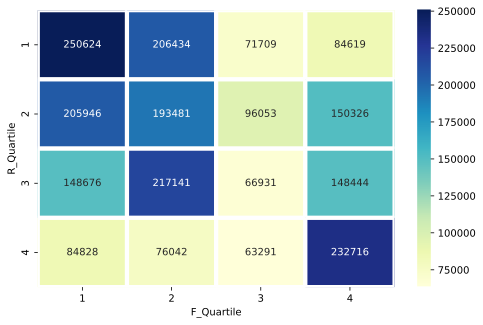

In [50]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.sum).applymap(int)

heatmap = sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", 
            linewidths=4.15, annot_kws={"size": 10})
plt.show()

**Кто наши лучшие клиенты?**

In [51]:
#RFMClass = 444
good = rfmTable[rfmTable['RFMClass']=='444'].sort_values('monetary_value', ascending=False)
good.head()

,customer,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
368,Jesus Ocampo,215,5,1091,4,4,4,444
222,Dennis Bolton,264,5,1081,4,4,4,444
164,Cindy Schnelling,424,4,1077,4,4,4,444
598,Pauline Chand,882,2,1062,4,4,4,444
209,David Philippe,812,2,1059,4,4,4,444


**Какие клиенты находятся на пороге оттока??**

In [52]:
#покупатели с низким recency, которые давно делали покупки
rfmTable[rfmTable['R_Quartile'] <= 2 ].sort_values('monetary_value', ascending=False).head(5)

,customer,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
757,Tom Ashbrook,69,4,14595,2,4,1,241
6,Adrian Barton,41,10,14474,2,1,1,211
441,Ken Lonsdale,47,12,14174,2,1,1,211
334,Hunter Lopez,43,6,12874,2,3,1,231
672,Sanjit Engle,9,11,12210,1,1,1,111


**Кто - потерянные клиенты?**


In [53]:
#Покупатели чьи показатели rfm=111 - низкие 
lost = rfmTable[rfmTable['RFMClass']=='111'].sort_values('recency',ascending=False)
lost.head()

,customer,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
690,Shahid Collister,30,9,5993,1,1,1,111
782,Victoria Wilson,28,10,6134,1,1,1,111
102,Brenda Bowman,28,9,6766,1,1,1,111
270,Erin Smith,28,9,4659,1,1,1,111
556,Natalie DeCherney,27,9,4326,1,1,1,111


**Кто - лояльные клиенты?**

In [54]:
#покупатели с высоким frequency, часто покупающие
loyal = rfmTable[rfmTable['F_Quartile'] >= 3 ].sort_values('monetary_value', ascending=False)
loyal.head()

,customer,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
686,Sean Miller,79,5,25042,3,4,1,341
730,Tamara Chand,399,5,19052,4,4,1,441
622,Raymond Buch,96,6,15117,3,3,1,331
757,Tom Ashbrook,69,4,14595,2,4,1,241
334,Hunter Lopez,43,6,12874,2,3,1,231


**Также можем оценить количество покупателей в каждом rf сегменте**

    например, у нас есть 134 клиента которые находяться в зоне 4:4 , мы можем их потерять
        и 17 лояльных клиентов, а также видим 58 новых 

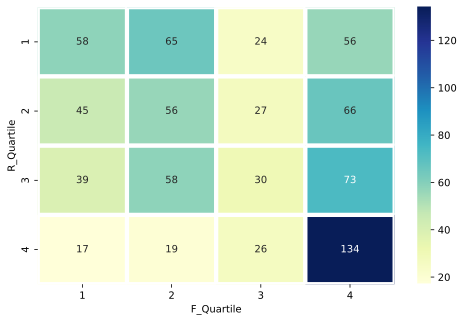

In [55]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='customer', 
                        aggfunc='count').applymap(int)

heatmap2 = sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", 
            linewidths=4.15, annot_kws={"size": 10})


### По итогам RFM анализа можем сделать выводы: 
      
      Новые клиенты принесли доход в 250624ед
      Самые лояльные покупатели , доход 84828ед
      Старые покупатели которые давно не делали заказ, принесли доход за все время 232716ед
на основе этих показателей мы можем расчитать оправданы ли были расходы на привлечение 

      Получен список из :
      - 436 лояльных покупателей, показатель лояльности 0.8 - хороший
      - 67 покупателей делают заказ часто, много и объемно по сумме 
      - 397 покупателей достаточно давно делали заказ, возможно стоит напомнить о себе
      - отток покупателей = 30 , не находиться в критичной зоне 
      
      
